In [3]:
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.express as px
import wandb
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from torchinfo import summary

# Classification of all (151) Gen 1 Pokémons

In [4]:
use_wandb = False

In [31]:
config = {
    "lr": 1e-3,
    "dataset": "Pokemons",
    "epochs": 100,
    "batch_size": 256,
    "fc_layers": [128*4*4, 256], 
    "image_shape": (64, 64),
    "activations": "ReLU",
    "loss": "cross-entropy",
    "optimizer": "Adam",
    "augment": True,
    "scheduler": True,
    "earlyStoppingValue": "loss" # loss/accuracy
}

In [6]:
if use_wandb:
    wandb.login()
    wandb.init(project="assignment-2", name="", reinit=True, config=config)

In [7]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = 'cpu'
print(f"Using {device} device")

Using mps device


## Data

In [8]:
data_dir = 'data/PokemonData/'

In [9]:
data = glob.glob('*/*.jpg', root_dir=data_dir)
print(len(data))
print(data[:5])

11942
['Zapdos/Zapdos60.jpg', 'Zapdos/Zapdos74.jpg', 'Zapdos/Zapdos48.jpg', 'Zapdos/Zapdos49.jpg', 'Zapdos/Zapdos75.jpg']


In [10]:
labels = sorted(glob.glob('*', root_dir=data_dir))
print(len(labels))
print(labels[:10])
print(labels[len(labels)-10:])

151
['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur']
['Vileplume', 'Voltorb', 'Vulpix', 'Wartortle', 'Weedle', 'Weepinbell', 'Weezing', 'Wigglytuff', 'Zapdos', 'Zubat']


In [11]:
for label in labels:
    print(label, len(os.listdir(os.path.join(data_dir, label))))

Abra 71
Aerodactyl 67
Alakazam 106
Arbok 91
Arcanine 66
Articuno 79
Beedrill 47
Bellsprout 66
Blastoise 57
Bulbasaur 50
Butterfree 75
Caterpie 65
Chansey 84
Charizard 88
Charmander 111
Charmeleon 44
Clefable 80
Clefairy 60
Cloyster 70
Cubone 79
Dewgong 66
Diglett 90
Ditto 56
Dodrio 68
Doduo 86
Dragonair 89
Dragonite 80
Dratini 71
Drowzee 65
Dugtrio 78
Eevee 102
Ekans 43
Electabuzz 72
Electrode 90
Exeggcute 61
Exeggutor 67
Farfetchd 71
Fearow 80
Flareon 87
Gastly 103
Gengar 134
Geodude 86
Gloom 99
Golbat 90
Goldeen 89
Golduck 78
Golem 88
Graveler 68
Grimer 93
Growlithe 111
Gyarados 134
Haunter 74
Hitmonchan 69
Hitmonlee 72
Horsea 81
Hypno 80
Ivysaur 88
Jigglypuff 76
Jolteon 87
Jynx 84
Kabuto 77
Kabutops 70
Kadabra 107
Kakuna 60
Kangaskhan 72
Kingler 69
Koffing 76
Krabby 85
Lapras 82
Lickitung 94
Machamp 67
Machoke 63
Machop 79
Magikarp 84
Magmar 74
Magnemite 74
Magneton 64
Mankey 102
Marowak 66
Meowth 84
Metapod 82
Mew 71
Mewtwo 99
Moltres 82
Mr.Mime 67
Muk 97
Nidoking 106
Nidoqueen 90


In [12]:
labels_map = dict()
reversed_labels_map = dict()

for i, label in enumerate(labels):
    labels_map[i] = label
    reversed_labels_map[label] = i

print(labels_map)
print(reversed_labels_map)

{0: 'Abra', 1: 'Aerodactyl', 2: 'Alakazam', 3: 'Arbok', 4: 'Arcanine', 5: 'Articuno', 6: 'Beedrill', 7: 'Bellsprout', 8: 'Blastoise', 9: 'Bulbasaur', 10: 'Butterfree', 11: 'Caterpie', 12: 'Chansey', 13: 'Charizard', 14: 'Charmander', 15: 'Charmeleon', 16: 'Clefable', 17: 'Clefairy', 18: 'Cloyster', 19: 'Cubone', 20: 'Dewgong', 21: 'Diglett', 22: 'Ditto', 23: 'Dodrio', 24: 'Doduo', 25: 'Dragonair', 26: 'Dragonite', 27: 'Dratini', 28: 'Drowzee', 29: 'Dugtrio', 30: 'Eevee', 31: 'Ekans', 32: 'Electabuzz', 33: 'Electrode', 34: 'Exeggcute', 35: 'Exeggutor', 36: 'Farfetchd', 37: 'Fearow', 38: 'Flareon', 39: 'Gastly', 40: 'Gengar', 41: 'Geodude', 42: 'Gloom', 43: 'Golbat', 44: 'Goldeen', 45: 'Golduck', 46: 'Golem', 47: 'Graveler', 48: 'Grimer', 49: 'Growlithe', 50: 'Gyarados', 51: 'Haunter', 52: 'Hitmonchan', 53: 'Hitmonlee', 54: 'Horsea', 55: 'Hypno', 56: 'Ivysaur', 57: 'Jigglypuff', 58: 'Jolteon', 59: 'Jynx', 60: 'Kabuto', 61: 'Kabutops', 62: 'Kadabra', 63: 'Kakuna', 64: 'Kangaskhan', 65: 'K

In [13]:
class PokemonDataset(Dataset):
    def __init__(self, imgs, data_dir, labels_map, transform=None, augment=False):
        self.labels_map = labels_map
        self.imgs = imgs
        self.data_dir = data_dir
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.imgs)
    
    def __augment(self, image):
        if random.random() > 0.4:
            angle = random.randint(-90, 90)
            image = TF.rotate(image, angle)
        
        # if random.random() > 0.2:
        #     image = TF.hflip(image)
        
        # if random.random() > 0.6:
        #     image = TF.vflip(image)
            
        return image

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.imgs[idx])
        image = read_image(img_path, ImageReadMode.RGB).float()
        image = image / 255.0
        label = self.labels_map[self.imgs[idx].split('/')[0]]

        if self.transform:
            image = self.transform(image)
        
        if self.augment:
            image = self.__augment(image)
        
        return image, label

In [14]:
data_train, data_val = train_test_split(data, test_size=0.3, train_size=0.7, random_state=420)
print(f'train: {len(data_train)}, val: {len(data_val)} | {len(data_train)+len(data_val)}')

train: 8359, val: 3583 | 11942


In [32]:
train_data = PokemonDataset(data_train, data_dir, reversed_labels_map, transform=transforms.Resize(config['image_shape']), augment=config['augment'])
val_data = PokemonDataset(data_val, data_dir, reversed_labels_map, transform=transforms.Resize(config['image_shape']), augment=False)

73 Magikarp
torch.Size([3, 128, 128])
[0.0000000e+00 3.7997379e-04 8.6077524e-04 ... 9.9999827e-01 9.9999899e-01
 1.0000000e+00]


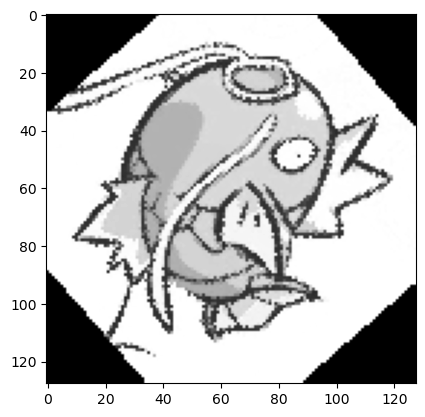

In [66]:
img, y = train_data.__getitem__(1)
print(y, labels_map[y])
print(img.shape)
print(np.unique(img))
plt.imshow(img[0,:,:], cmap='gray')

In [33]:
train_dataloader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=config['batch_size'], shuffle=False)

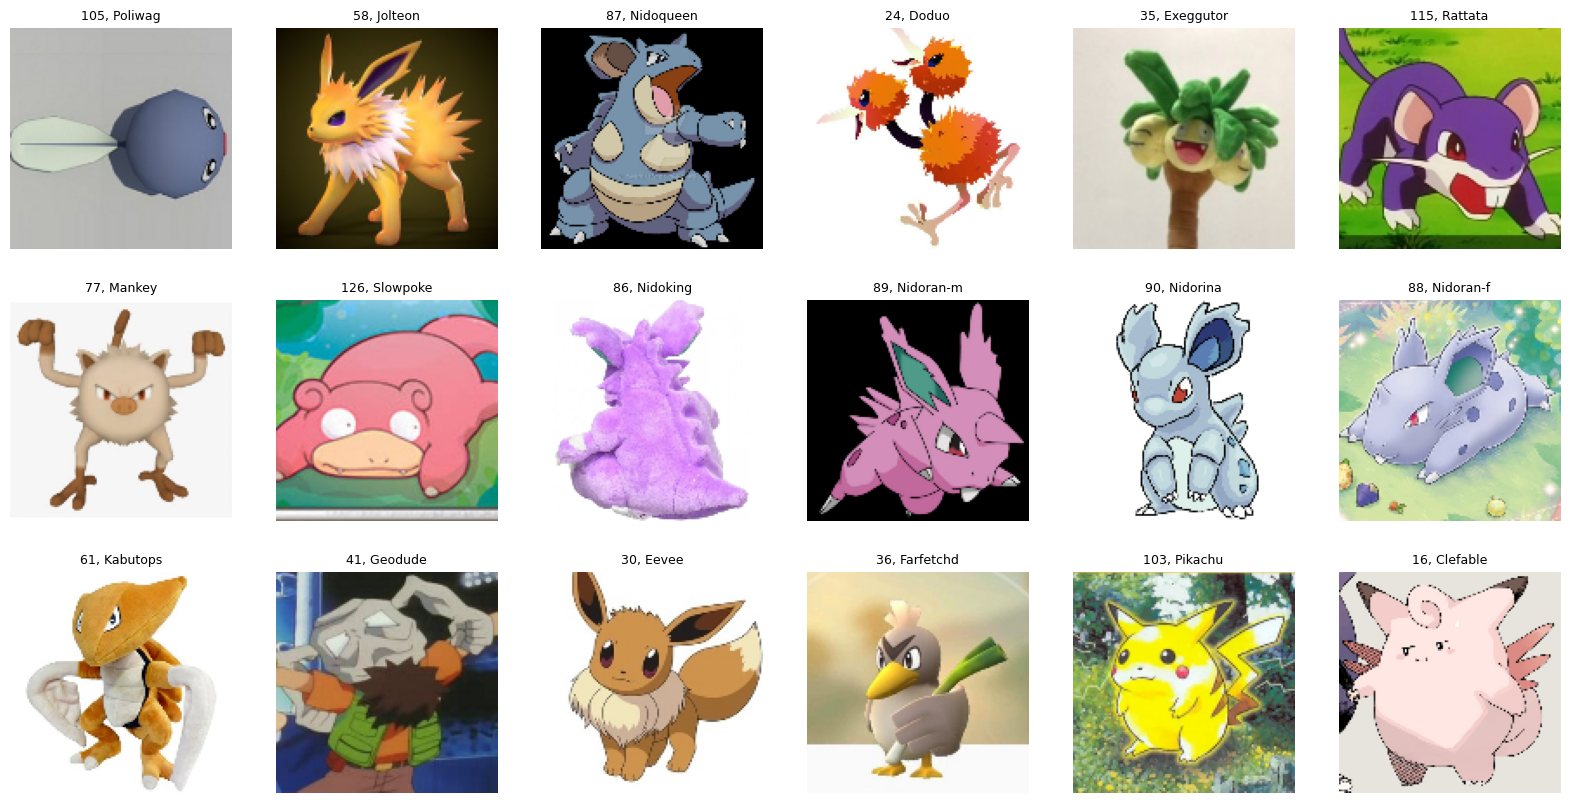

In [81]:
fig, axs = plt.subplots(3, 6, figsize=(20, 10))
axs = axs.flatten()

images, labels = next(iter(val_dataloader))
for i, (img, label) in enumerate(zip(images, labels)):
    if i == 18: break
    axs[i].imshow(img[:,:,:].permute(1, 2, 0))
    axs[i].set_title(f'{label.item()}, {labels_map[label.item()]}', fontsize=9)
    axs[i].axis('off')
plt.show()

## Model

In [19]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # 16 x 128 x 128
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 16 x 64 x 64
            # nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # 32 x 64 x 64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 32 x 32 x 32
            # nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # 64 x 32 x 32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 64 x 16 x 16
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(64*16*16, 256), 
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(256, 151),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.conv(x)
        out = self.flatten(out)
        out = self.fc(out)
        
        return out
    

summary(NeuralNetwork(), (256, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [256, 151]                --
├─Sequential: 1-1                        [256, 64, 16, 16]         --
│    └─Conv2d: 2-1                       [256, 16, 128, 128]       448
│    └─BatchNorm2d: 2-2                  [256, 16, 128, 128]       32
│    └─ReLU: 2-3                         [256, 16, 128, 128]       --
│    └─MaxPool2d: 2-4                    [256, 16, 64, 64]         --
│    └─Conv2d: 2-5                       [256, 32, 64, 64]         4,640
│    └─BatchNorm2d: 2-6                  [256, 32, 64, 64]         64
│    └─ReLU: 2-7                         [256, 32, 64, 64]         --
│    └─MaxPool2d: 2-8                    [256, 32, 32, 32]         --
│    └─Conv2d: 2-9                       [256, 64, 32, 32]         18,496
│    └─BatchNorm2d: 2-10                 [256, 64, 32, 32]         128
│    └─ReLU: 2-11                        [256, 64, 32, 32]         --
│    └

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(256*4*4, 256), 
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 151),
        )

    def forward(self, x):
        out = self.conv(x)
        out = self.flatten(out)
        out = self.fc(out)
        
        return out   
    
summary(NeuralNetwork(), (256, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [256, 151]                --
├─Sequential: 1-1                        [256, 256, 4, 4]          --
│    └─Conv2d: 2-1                       [256, 64, 64, 64]         1,792
│    └─BatchNorm2d: 2-2                  [256, 64, 64, 64]         128
│    └─ReLU: 2-3                         [256, 64, 64, 64]         --
│    └─Conv2d: 2-4                       [256, 64, 32, 32]         36,928
│    └─Dropout2d: 2-5                    [256, 64, 32, 32]         --
│    └─Conv2d: 2-6                       [256, 128, 32, 32]        73,856
│    └─BatchNorm2d: 2-7                  [256, 128, 32, 32]        256
│    └─ReLU: 2-8                         [256, 128, 32, 32]        --
│    └─Conv2d: 2-9                       [256, 128, 16, 16]        147,584
│    └─Dropout2d: 2-10                   [256, 128, 16, 16]        --
│    └─Conv2d: 2-11                      [256, 256, 16, 16]        

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128*4*4, 256), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 151),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.conv(x)
        out = self.flatten(out)
        out = self.fc(out)
        
        return out

summary(NeuralNetwork(), (256, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [256, 151]                --
├─Sequential: 1-1                        [256, 128, 4, 4]          --
│    └─Conv2d: 2-1                       [256, 32, 64, 64]         896
│    └─BatchNorm2d: 2-2                  [256, 32, 64, 64]         64
│    └─ReLU: 2-3                         [256, 32, 64, 64]         --
│    └─Conv2d: 2-4                       [256, 32, 32, 32]         9,248
│    └─Dropout: 2-5                      [256, 32, 32, 32]         --
│    └─Conv2d: 2-6                       [256, 64, 32, 32]         18,496
│    └─BatchNorm2d: 2-7                  [256, 64, 32, 32]         128
│    └─ReLU: 2-8                         [256, 64, 32, 32]         --
│    └─Conv2d: 2-9                       [256, 64, 16, 16]         36,928
│    └─Dropout: 2-10                     [256, 64, 16, 16]         --
│    └─Conv2d: 2-11                      [256, 128, 16, 16]        73,85

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(p=0.4),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(p=0.4),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(256*4*4, 256), 
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 151),
        )

    def forward(self, x):
        out = self.conv(x)
        out = self.flatten(out)
        out = self.fc(out)
        
        return out  
    
summary(NeuralNetwork(), (256, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [256, 151]                --
├─Sequential: 1-1                        [256, 256, 4, 4]          --
│    └─Conv2d: 2-1                       [256, 64, 64, 64]         1,792
│    └─BatchNorm2d: 2-2                  [256, 64, 64, 64]         128
│    └─ReLU: 2-3                         [256, 64, 64, 64]         --
│    └─Conv2d: 2-4                       [256, 64, 32, 32]         36,928
│    └─Dropout2d: 2-5                    [256, 64, 32, 32]         --
│    └─Conv2d: 2-6                       [256, 128, 32, 32]        73,856
│    └─BatchNorm2d: 2-7                  [256, 128, 32, 32]        256
│    └─ReLU: 2-8                         [256, 128, 32, 32]        --
│    └─Conv2d: 2-9                       [256, 128, 16, 16]        147,584
│    └─Dropout2d: 2-10                   [256, 128, 16, 16]        --
│    └─Conv2d: 2-11                      [256, 256, 16, 16]        

In [24]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): Dropout2d(p=0.3, inplace=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): Dropout2d(p=0.3, inplace=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): Dropout2d(p=0.4, inplace=False)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

Early stopping

In [ ]:
# https://stackoverflow.com/a/73704579
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_value = np.inf
        self.max_value = 0
        self.mode = mode

    def __call__(self, value): 
        if self.mode == 'min':
            if value < self.min_value:
                self.min_value = value
                self.counter = 0     
            elif value > (self.min_value + self.min_delta):
                self.counter += 1
                print(f'Early stopping: {self.counter}/{self.patience}')
                
        elif self.mode == 'max':
            if value > self.max_value:
                self.max_value = value
                self.counter = 0     
            elif value < (self.max_value - self.min_delta):
                self.counter += 1
                print(f'Early stopping: {self.counter}/{self.patience}')
                
        if self.counter >= self.patience:
            return True
        
        # print((self.min_value + self.min_delta))
        
        return False

Calculating accuracy

In [ ]:
def calculate_acc(y_pred, y):
    # preds = F.softmax(y_pred, dim=1)
    preds = torch.argmax(y_pred, dim=1)
    num_correct = (preds == y).sum().item()
    
    # print(preds, y)
    # print((preds == y).sum())

    return num_correct / len(y)

Training for one epoch

In [ ]:
def train(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    avg_loss, avg_acc = 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        # Get prediction and compute loss
        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        avg_loss += loss.item()

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_acc += calculate_acc(y_pred, y)
    
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)
        
    return (avg_loss, avg_acc)

Validation for one epoch

In [ ]:
def val(dataloader, model, loss_fn, epoch):    
    model.eval()
    avg_loss, avg_acc = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            avg_loss += loss_fn(y_pred, y).item()
            avg_acc += calculate_acc(y_pred, y)
    
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)
    
    return (avg_loss, avg_acc)

In [ ]:
if config['earlyStoppingValue'] == 'loss':
    early_stopper = EarlyStopper(patience=5, min_delta=0.1, mode='min')
elif config['earlyStoppingValue'] == 'accuracy':
    early_stopper = EarlyStopper(patience=5, min_delta=0.1, mode='max')

optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

if config['scheduler']:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
epochs = config['epochs']
train_history = {'loss': [], 'acc': []}
val_history = {'loss': [], 'acc': []}
best_epoch = {}
    
for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer, epoch)
    val_loss, val_acc = val(val_dataloader, model, loss_fn, epoch)

    train_history['loss'].append(train_loss)
    train_history['acc'].append(train_acc)

    val_history['loss'].append(val_loss)
    val_history['acc'].append(val_acc)

    if config['scheduler']:
        scheduler.step(val_loss)
    
    # if (epoch % 10 == 0):
    print(f'Epoch {epoch}')
    print(f'loss: {train_loss:>5f} acc: {train_acc:>5f}')
    print(f'val loss: {val_loss:>5f} val acc: {val_acc:>5f}')
    # print(f'lr: {optimizer.param_groups[0]["lr"]:>5f}')
    print('-------------------------------')

    if use_wandb:
        wandb.log({
            'epoch': epoch, 'loss': train_loss, 'accuracy': train_acc, 
            'val_loss':val_loss, 'val_accuracy': val_acc, 'lr': optimizer.param_groups[0]["lr"]
        })
    
    if early_stopper(val_loss):
        print('Stopping early!!!')
        break

In [ ]:
torch.save(model, 'models/model.pt')
if use_wandb:
    artifact = wandb.Artifact('model', type='model')
    artifact.add_file('models/model.pt')
    wandb.log_artifact(artifact)
    wandb.finish()

accuracy,▁▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▄▅▅▆▆▆▆▆▇▇▇████
val_loss,█▇▆▅▄▄▃▃▃▂▃▂▂▂▂▂▁▁▁▁
accuracy,0.4358
epoch,19
loss,2.09517
lr,0.001
val_accuracy,0.3698


In [ ]:
fig = px.line({'loss': train_history['loss'], 'val_loss': val_history['loss']})
fig.show()

In [ ]:
fig = px.line({'acc': train_history['acc'], 'val_acc': val_history['acc']})
fig.show()

In [26]:
# torch.save(model, 'models/overfitted.pt')
model = NeuralNetwork()
model.load_state_dict(torch.load('models/model.pt', map_location=torch.device('mps')))

<All keys matched successfully>

In [ ]:
# model = NeuralNetwork()
# model.load_state_dict(torch.load('models/overfitted.pt'))
# model.eval()

In [34]:
def plot_img(img, label):
    print(f'Original image: {label.item()} {labels_map[label.item()]}')
    plt.imshow(img[0,:,:], cmap='gray')

Original image: 137 Venomoth
Predicted: 48 Grimer


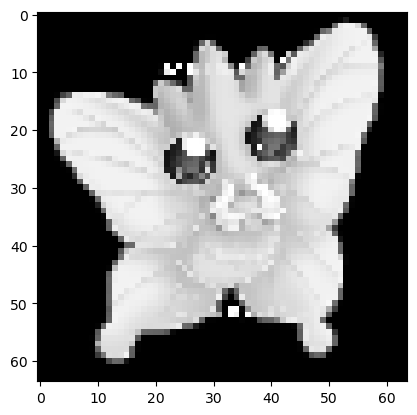

In [37]:
model.eval()
index = 127
with torch.no_grad():
    x, y = next(iter(val_dataloader))
    plot_img(x[index], y[index])
    
    #x = x.to(device)
    y_pred = model(x)
    y_pred_labels = torch.argmax(y_pred, dim=1)
    
    print('Predicted:', y_pred_labels[index].item(), labels_map[y_pred_labels[index].item()])
    # print(y_pred_labels)

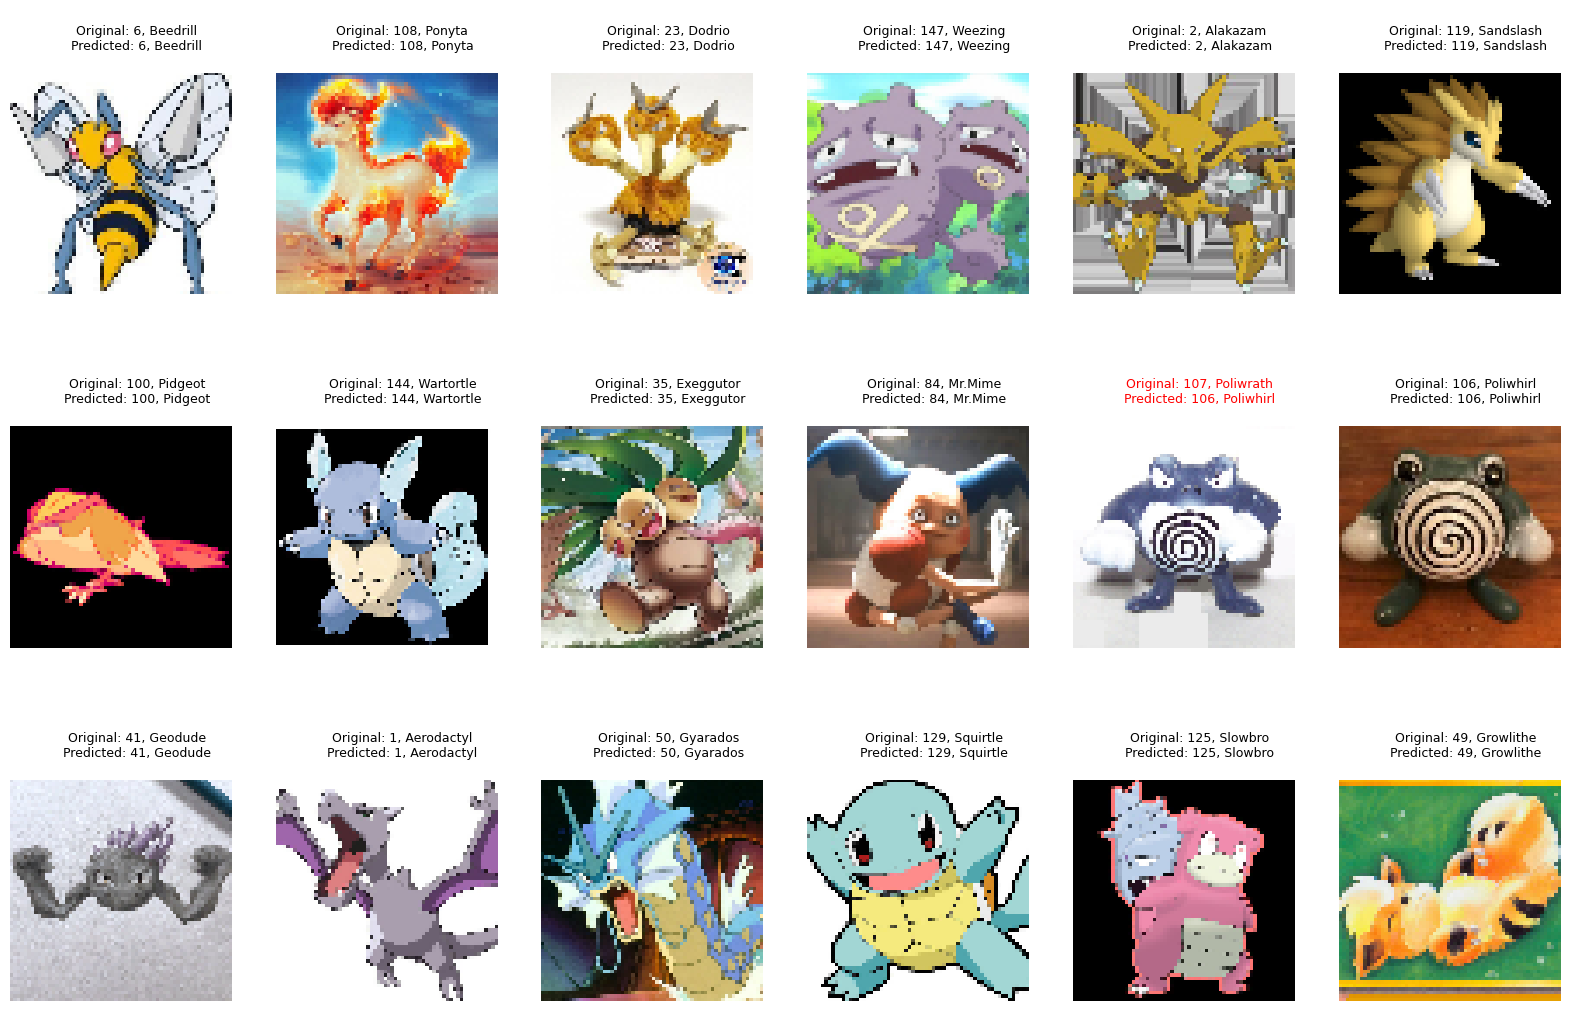

In [60]:
fig, axs = plt.subplots(3, 6, figsize=(20, 13))
axs = axs.flatten()

model.eval()
with torch.no_grad():
    images, labels = next(iter(val_dataloader))
    
    y_pred = model(images)
    y_pred_labels = torch.argmax(y_pred, dim=1) 
    for i, (img, label) in enumerate(zip(images, labels)):
        if i == 18: break

        title = f'''
        Original: {labels[i].item()}, {labels_map[labels[i].item()]}
        Predicted: {y_pred_labels[i].item()}, {labels_map[y_pred_labels[i].item()]}
        '''
        title_color = 'black' if labels[i].item() == y_pred_labels[i].item() else 'red' 
        axs[i].imshow(img[:,:,:].permute(1, 2, 0))
        axs[i].set_title(title, fontsize=9, color=title_color)
        axs[i].axis('off')
    plt.show()